In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# Load cdm simulation data
base_dir_cdm = '/Users/susannedahle/CellTypeDependenceElStim/cdm_and_imem_data_neo' 

cdm_amp_file_paths = [
    os.path.join(base_dir_cdm, f'cdm_and_imem_data_neo_{i}.npy')
    for i in range(8)
]

cdm_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in cdm_amp_file_paths
]
cdm_amp_data = {}
for data in cdm_amp_data_list:
    cdm_amp_data.update(data)

In [2]:
def calculate_transfer_function(params, freqs):
    """
    Calculates T_p

    Args:
        params (dict): A dictionary containing the biophysical parameters.
        freqs (np.ndarray): An array of frequencies (in Hz) to calculate the PSD for.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The input frequency array.
            - abs_T_p (np.ndarray): The absolute value of the calculated Transfer function for the ball-and-two-stick model.
    """
    # --- 1. Extract parameters and convert to SI units ---
    Rm = params['Rm']  # Specific membrane resistance (Ohm * m^2)
    Ri = params['Ri']  # Axial resistivity (Ohm * m)
    Cm = params['Cm']  # Specific membrane capacitance (F / m^2)
    d = params['d']    # Stick diameter (m)
    ds = params['ds']  # Soma diameter (m)
    l1 = params['l1']  # Length of stick 1 (m)
    l2 = params['l2']  # Length of stick 2 (m)
    s_in = params['s_in'] # PSD of white noise input current (A^2 / Hz)

    # --- 2. Calculate derived cable properties ---
    # Angular frequency
    omega = 2 * np.pi * freqs
    # Add a small epsilon to the first frequency to avoid division by zero if f=0
    omega[0] = omega[0] + 1e-9

    # Membrane time constant (s)
    tau_m = Rm * Cm

    # Length constant (m)
    # This is the standard definition from cable theory (e.g., Rall, 1959)
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))

    # Electrotonic lengths (dimensionless)
    L1 = l1 / lambda_
    L2 = l2 / lambda_

    # Dimensionless frequency
    W = omega * tau_m

    # Complex frequency-dependent term q
    q = np.sqrt(1 + 1j * W)

    # --- 3. Calculate admittances (inverse of impedance) ---
    # Admittance of the soma (S)
    Ys = np.pi * ds**2 * (1/Rm) * q**2

    # Infinite-stick admittance (S)
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf

    # Total input admittance seen by the soma (S)
    # This is the parallel sum of the soma and the two finite sticks.
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    # --- 4. Calculate the transfer function T_p(f) ---
    # Derived for the ball-and-two-stick model.
    # The numerator represents the difference in dipole moments from the two sticks.
    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))

    # The denominator is the total admittance
    denominator = Y_in_total

    T_p = numerator / denominator
    abs_T_p = np.abs(T_p)

    return freqs, abs_T_p

In [3]:
avg_cdm_data_celltype = []

def calculate_avg_cdm_per_Iin(cdm_data):
    """ Categorizes cells based on their names and calculates the average and standard deviation of soma amplitudes for each frequency within each category. """
    global avg_cdm_data_celltype

    # Clear the lists to avoid duplicate entries
    avg_cdm_data_celltype = []

    # Dictionary to store categorized data
    categorized_data = {}

    # Loop through each cell and organize data by category
    for cell_name, data in cdm_data.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: cell_category = 'Inhibitory neurons'
            
        
        # Initialize category in dictionary if not present
        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}
        
        # Organize soma amplitudes by frequency
        for freq, cdm_amp in zip(data['frequency'], data['cdm_per_input_current']):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = []
            categorized_data[cell_category][freq].append(cdm_amp)
    
    # Compute averages and standard deviations
    for category, freq_data in categorized_data.items():
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'cdm_per_input_current': [],
            'std': []
        }
        
        for freq, amplitudes in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['cdm_per_input_current'].append(np.mean(amplitudes))
            category_result['std'].append(np.std(amplitudes))
        

        avg_cdm_data_celltype.append(category_result)

In [10]:
def population_tf_and_cdm_per_inp_current(avg_cdm_data_celltype, freqs_pyr, abs_T_p_pyr , freqs_inhb, abs_T_p_inhb):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.rcParams['mathtext.fontset'] = 'stix'

    # Plot average data for each cell type
    for cell_data in avg_cdm_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = cell_data['frequencies']
        avg_cdm_amplitudes = np.array(cell_data['cdm_per_input_current'])
        std_cdm_amplitudes = np.array(cell_data['std'])

        upper_line = (avg_cdm_amplitudes + std_cdm_amplitudes)*1e-6
        bottom_line = (avg_cdm_amplitudes - std_cdm_amplitudes)*1e-6
        
        if cell_category == 'Pyramidal cells':
            color = 'tab:green'
            ax.loglog(frequencies, avg_cdm_amplitudes*1e-6, linestyle='--', linewidth=2, label='Pyramidal cells Average $p_\mathrm{z}$ / $I_\mathrm{in}$', color=color) #, marker = '.', markersize = 10
        elif cell_category == 'Spiny Stellate cells':
            color = 'tab:purple'
            color = 'white'
        else:
            color = 'tab:orange'
            ax.loglog(frequencies, avg_cdm_amplitudes*1e-6, linestyle='--', linewidth=2, label='Inhibitory neurons Average $p_\mathrm{z}$ / $I_\mathrm{in}$', color=color) #, marker = '.', markersize = 10

        #ax.loglog(frequencies, avg_cdm_amplitudes*1e-6, linestyle='--', linewidth=2, label=f'{cell_category} Average cdm per input current', color=color) #, marker = '.', markersize = 10
        #ax.fill_between(frequencies, bottom_line, upper_line, color=color, alpha=0.2 )

    ax.loglog(freqs_pyr, abs_T_p_pyr,
                label='$|\mathbf{T}_p|$ for avg pyramidal properties',
                linewidth=2.5, color='tab:green')

    ax.loglog(freqs_inhb, abs_T_p_inhb,
                label='$|\mathbf{T}_p|$ for avg inhibitory properties',
                linewidth=2.5, color='tab:orange')


    # Formatting the plot
    # ax.set_title('Transfer function', fontsize=9, pad=20)
    ax.set_xlabel('Frequency (Hz)', fontsize=9)
    ax.set_ylabel('Dipole moment per input current (m)', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, which="both", ls="-", alpha=0.5)
    ax.set_xlim(frequencies[0], frequencies[-1])

    plt.tight_layout()
    plt.show()
    

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_21317/3100249768.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.loglog(frequencies, avg_cdm_amplitudes*1e-6, linestyle='--', linewidth=2, label='Pyramidal cells Average $p_\mathrm{z}$ / $I_\mathrm{in}$', color=color) #, marker = '.', markersize = 10
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_21317/3100249768.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.loglog(frequencies, avg_cdm_amplitudes*1e-6, linestyle='--', linewidth=2, label='Inhibitory neurons Average $p_\mathrm{z}$ / $I_\mathrm{in}$',

In [7]:
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 0.7e-6,          # 2 um -> m
    'ds': 10e-6,        # 20 um -> m
    'l1': 0.67e-3,         # 0.67 mm -> m (Longer stick)
    'l2': 0.25e-3,       # 0.33 mm -> m (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

# --- Define frequency range for analysis ---
# From 1 Hz to 10,000 Hz, with 1000 points logarithmically spaced.
frequencies = np.logspace(0, 3.4, 1000)

avg_l1_pyr = 787.18
avg_l2_pyr = 254.91
avg_l1_inhb = 220.90
avg_l2_inhb = 280.45

In [8]:
pyramidal_parameters = standard_neuron_parameters.copy()
pyramidal_parameters['l1'] = avg_l1_pyr*1e-6
pyramidal_parameters['l2'] = avg_l2_pyr*1e-6
freqs_pyr, abs_T_p_pyr = calculate_transfer_function(pyramidal_parameters, frequencies.copy())


inhb_parameters = standard_neuron_parameters.copy()
inhb_parameters['l1'] = avg_l1_inhb *1e-6
inhb_parameters['l2'] = avg_l2_inhb *1e-6
freqs_inhb, abs_T_p_inhb = calculate_transfer_function(inhb_parameters, frequencies.copy())

In [9]:
calculate_avg_cdm_per_Iin(cdm_amp_data)

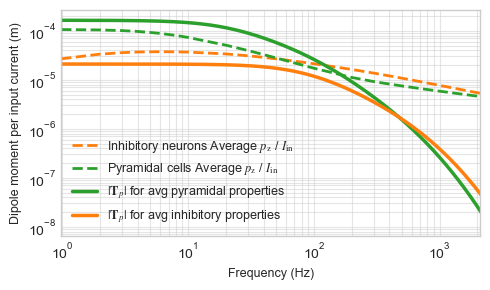

In [11]:
population_tf_and_cdm_per_inp_current(avg_cdm_data_celltype, freqs_pyr, abs_T_p_pyr , freqs_inhb, abs_T_p_inhb)